In [37]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34806")
client

<Client: 'tcp://127.0.0.1:34806' processes=5 threads=5, memory=40.00 GiB>

In [38]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import os
import pickle

import SAM
import cluster_utils as flt

In [85]:
# Number of classes 
n_classes = 5
model_folder = 'model'
data_folder = 'data'

ids = ['r1i1p1f2', 'r3i1p1f2', 'r2i1p1f2', 'r8i1p1f2', 'r4i1p1f2', 'r5i1p1f3', 'r7i1p1f3', 'r9i1p1f2', 'r6i1p1f3', 'r10i1p1f2']
areas = []
mean_lats=[]
SAMs=[]
avgs=[]

timeslice=slice('1965-01', '1994-12')

In [86]:
for m_id in ids:
    path_n_data = '{}/{}/{}'.format(data_folder, m_id, n_classes)
    with open('{}/avg.obj'.format(path_n_data), 'rb') as file:
        avg=pickle.load(file)
        file.close()
        inds = flt.temp_sort(None, avg, True)
     #   avg_prof=[]
    #    std_prof=[]
    #    for i in range(0,n_classes):
    #        avg_prof.append(xr.DataArray(avg[inds[i]]['mean'],dims=['lev']))
     #       std_prof.append(xr.DataArray(avg[inds[i]]['std'],dims=['lev']))
     #   avg_prof=xr.concat(avg_prof,'k')
     #   avg_prof.name='avg_prof'
     #   std_prof=xr.concat(std_prof,'k')
     #   std_prof.name='std_prof'
    #    avgs.append(xr.merge([avg_prof,std_prof]))

    with open('{}/areas.obj'.format(path_n_data), 'rb') as file:
        areas.append(pickle.load(file).isel(k=inds))
        file.close()
    with open('{}/mean_lats.obj'.format(path_n_data), 'rb') as file:
        mean_lats.append(pickle.load(file).isel(k=inds))
        file.close()        
    options = {'memberId' : m_id}
    SAMs.append(SAM.retrieve_SAM(timeRange=timeslice, options=options))

In [87]:
data_areas=xr.concat(areas,'id')
data_areas['id']=ids
data_areas.name='areas'
data_lats=xr.concat(mean_lats,'id')
data_lats['id']=ids
data_lats.name='lats'
data_sam=xr.concat(SAMs,'id')
data_sam['id']=ids
data_sam.name='SAM'
#data_prof=xr.concat(avgs,'id')
#data_prof['id']=ids
data_all=xr.merge([data_areas,data_lats,data_sam])
data_all

<xarray.Dataset>
Dimensions:  (time: 360, id: 10, k: 5)
Coordinates:
  * time     (time) datetime64[ns] 1965-01-01 1965-02-01 ... 1994-12-01
  * id       (id) <U9 'r1i1p1f2' 'r3i1p1f2' ... 'r6i1p1f3' 'r10i1p1f2'
Dimensions without coordinates: k
Data variables:
    areas    (id, time, k) float64 3.071e+03 2.705e+03 ... 2.874e+03 2.153e+03
    lats     (id, time, k) float64 -21.56 -13.4 -7.748 ... -6.829 -6.803 -4.623
    SAM      (id, time) float32 dask.array<chunksize=(1, 360), meta=np.ndarray>

In [88]:
data_anom=SAM.monthly_mean(data_all)
data_anom

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 30 times more chunks
  return self.array[key]


<xarray.Dataset>
Dimensions:  (time: 360, id: 10, k: 5)
Coordinates:
  * time     (time) datetime64[ns] 1965-01-01 1965-02-01 ... 1994-12-01
  * id       (id) <U9 'r1i1p1f2' 'r3i1p1f2' ... 'r6i1p1f3' 'r10i1p1f2'
    month    (time) int64 dask.array<chunksize=(360,), meta=np.ndarray>
Dimensions without coordinates: k
Data variables:
    areas    (id, time, k) float64 dask.array<chunksize=(10, 360, 5), meta=np.ndarray>
    lats     (id, time, k) float64 dask.array<chunksize=(10, 360, 5), meta=np.ndarray>
    SAM      (id, time) float32 dask.array<chunksize=(10, 360), meta=np.ndarray>

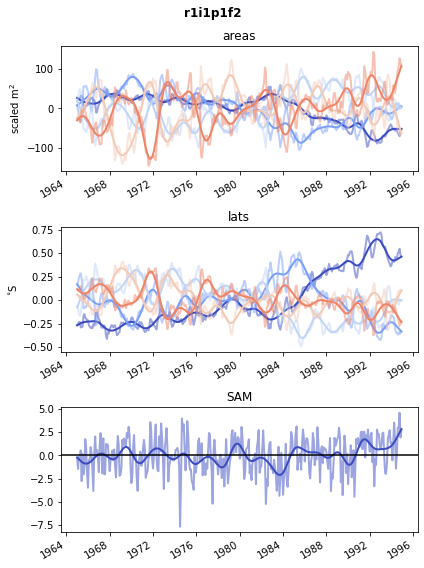

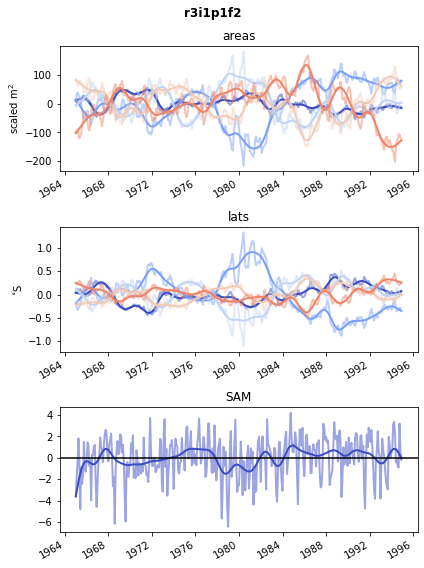

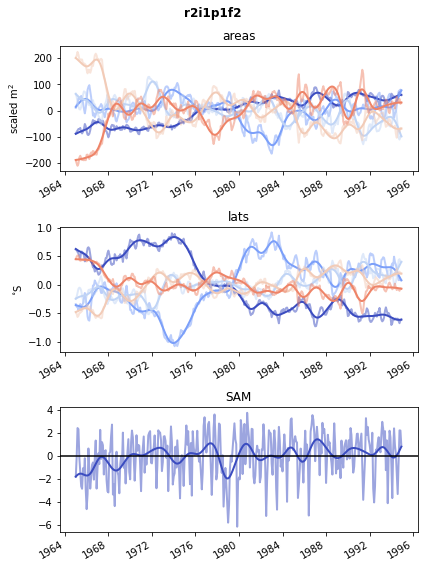

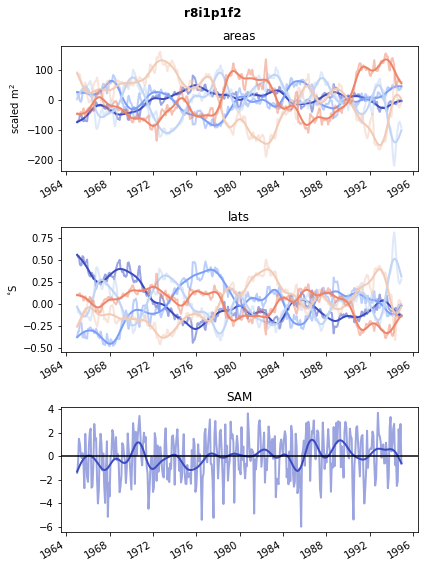

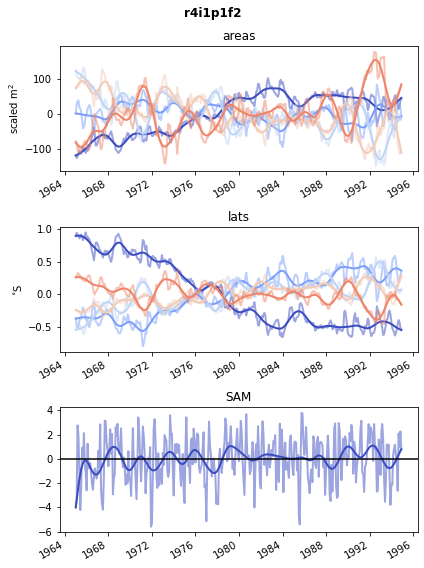

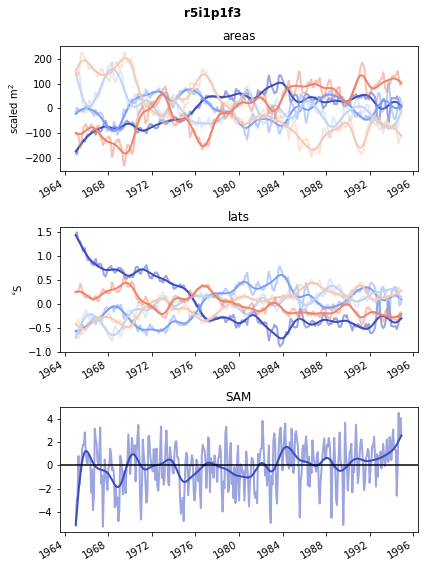

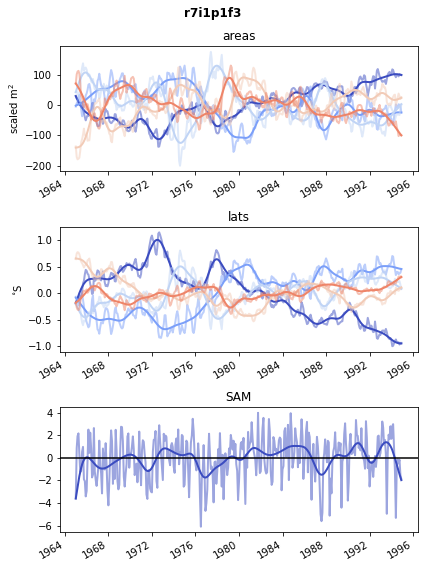

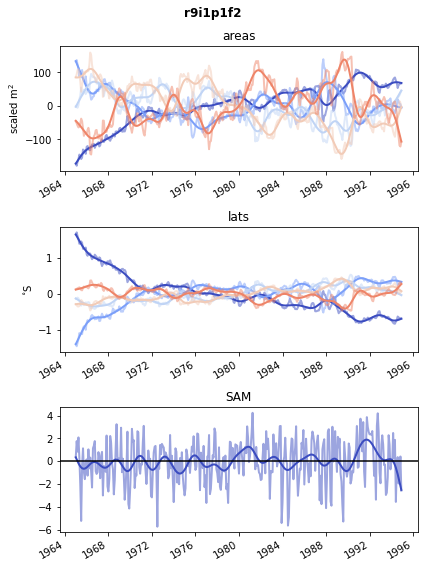

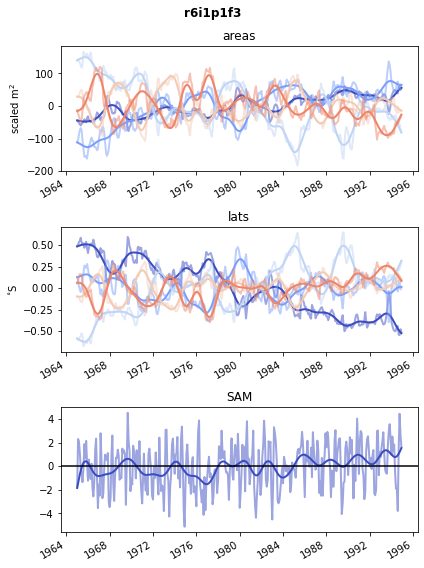

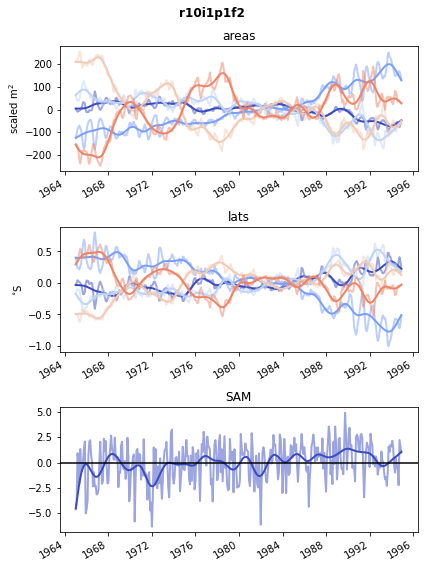

In [89]:
for m_id in ids:
    plt.figure(figsize=[6,8])
    vars=['areas','lats','SAM']
    units=dict(zip(vars,['scaled m$^2$','$^{\circ}$S','']))
    cmap=plt.colormaps['coolwarm']
    pp=1
    for var in vars:
        ax=plt.subplot(3,1,pp)
        if 'k' in data_anom[var].dims:
            for k in range(0,n_classes):
                data_anom[var].sel(id=m_id).isel(k=k).plot(linewidth=2,alpha=0.5,color=cmap(k/n_classes))
                SAM.BW_filter(data_anom[var].isel(k=k).sel(id=m_id),4,1/12,'time').plot(linewidth=2,color=cmap(k/n_classes))
        else:
            data_all[var].sel(id=m_id).plot(linewidth=2,alpha=0.5,color=cmap(0))
            SAM.BW_filter(data_all[var].sel(id=m_id),4,1/12,'time').plot(linewidth=2,color=cmap(0))
            plt.axhline(0,color='k')
        plt.title(var)
        plt.ylabel(units[var])
        plt.xlabel('')
        pp+=1
    plt.suptitle(m_id,fontweight='bold',fontsize=12)
    plt.tight_layout()
    plt.savefig('figures/areaslatsSAM-{}classes-{}'.format(n_classes,m_id))

In [44]:
import scipy.stats as stats
def new_linregress(x,y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return np.array([slope, intercept, r_value, p_value, std_err])
def lin_regress(X,Y,indims,dtype='float64'):    
    dstats = xr.apply_ufunc(
    new_linregress,  # first the function
    X,  # now arguments in the order expected by func
    Y,  # as above
    input_core_dims=indims,  # list with one entry per arg
    output_core_dims=[['parameter']],  # returned data has one dimension
    vectorize=True,  # loop over non-core dims
    dask='parallelized',
    output_dtypes=[dtype],  # one per output
    dask_gufunc_kwargs={'output_sizes':{"parameter": 5}},
#    output_sizes={"parameter": 5},
    )
    dstats['parameter']=('parameter',["slope","intercept","r_value","p_value","std_err"])
    return dstats

In [93]:
freq='low'
all_stats=[]
lag_length=12*5
for var in ['areas','lats']:
    var_stats=[]
    if freq == 'low':
        XX=SAM.BW_filter(data_all['SAM'],4,1/12,'time').isel(time=slice(lag_length,-lag_length)).drop_vars('time')
    elif freq=='high':
        XX=(data_all['SAM']-SAM.BW_filter(data_all['SAM'],4,1/12,'time')).isel(time=slice(lag_length,-lag_length)).drop_vars('time')   
    for lag in range(-lag_length,lag_length):
        if freq=='low':
            YY=SAM.BW_filter(data_anom[var],4,1/12,'time').isel(time=slice(lag_length+lag,-lag_length+lag)).drop_vars('time')
        elif freq=='high':
            YY=(data_anom[var]-SAM.BW_filter(data_anom[var],4,1/12,'time')).isel(time=slice(lag_length+lag,-lag_length+lag)).drop_vars('time')
        dstats=lin_regress(XX,YY,[['time'],['time']])
        dstats['lag']=lag
        var_stats.append(dstats)
    if freq=='low':
        YY=SAM.BW_filter(data_anom[var],4,1/12,'time').isel(time=slice(lag_length*2,None)).drop_vars('time')
    elif freq=='high':
        YY=(data_anom[var]-SAM.BW_filter(data_anom[var],4,1/12,'time')).isel(time=slice(lag_length*2,None)).drop_vars('time')
    dstats=lin_regress(XX,YY,[['time'],['time']])
    dstats['lag']=lag_length
    var_stats.append(dstats)
    var_stats=xr.concat(var_stats,'lag').load()
    var_stats['var']=var
    all_stats.append(var_stats)
all_stats=xr.concat(all_stats,'var')

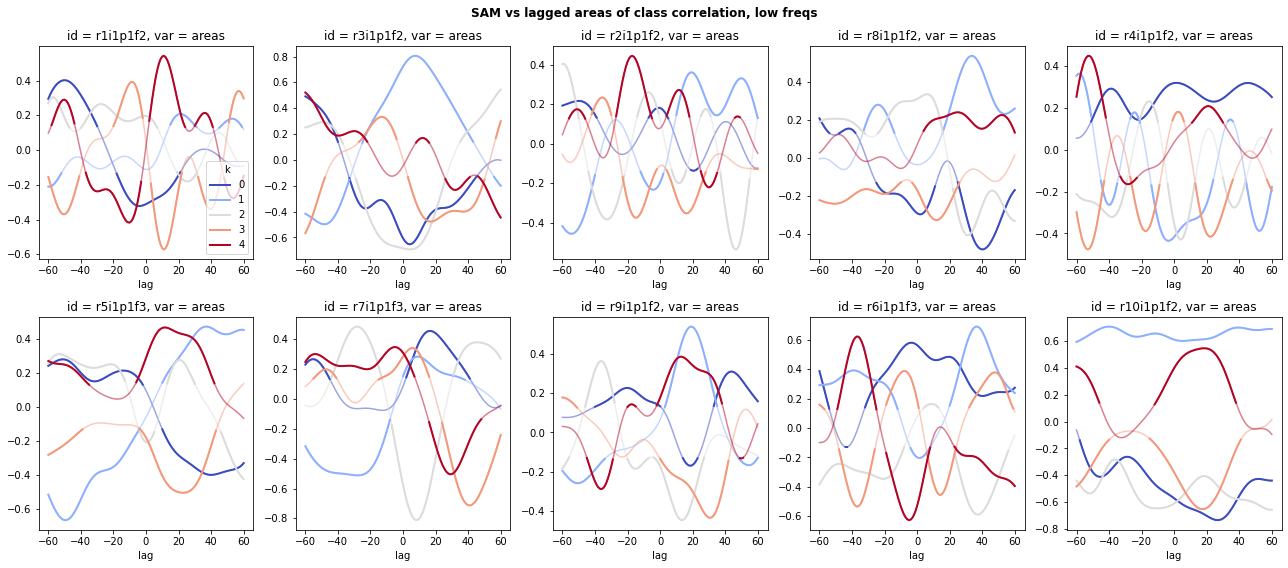

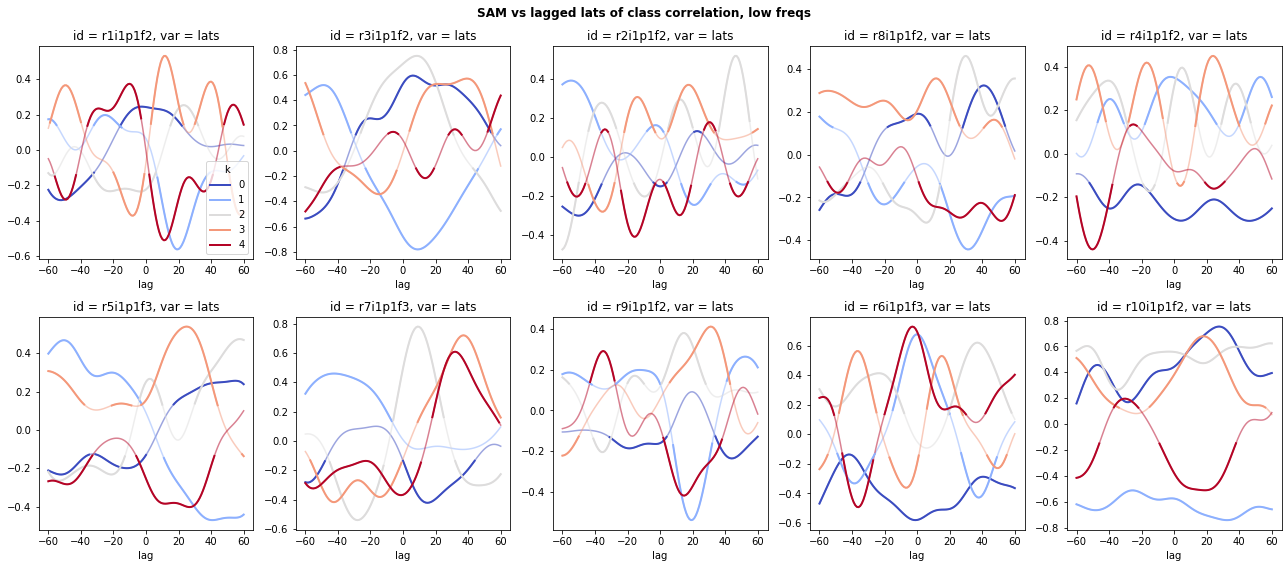

In [94]:
cmap=plt.cm.coolwarm(np.linspace(0, 1, n_classes))
for var in ['areas','lats']:
    pp=1
    plt.figure(figsize=[18,8])
    for m_id in ids:
        ax=plt.subplot(2,5,pp)
        ax.set_prop_cycle(color=cmap)
        plot1=all_stats.sel(id=m_id,var=var,parameter='r_value')
        plot2=plot1.where(all_stats.sel(id=m_id,var=var,parameter='p_value')<=0.05)
        plot1.plot(x='lag',hue='k',ax=ax,alpha=0.5,add_legend=False)
        plot2.plot(x='lag',hue='k',ax=ax,linewidth='2',add_legend=(m_id == 'r1i1p1f2'))
        pp+=1
        if freq=='high':
            plt.xlim(-18,18)
    plt.suptitle('SAM vs lagged {} of class correlation, {} freqs'.format(var,freq),fontweight='bold',fontsize=12)
    plt.tight_layout()
    plt.savefig('figures/SAMvs{}byExp-{}classes-{}freq'.format(var,n_classes,freq))

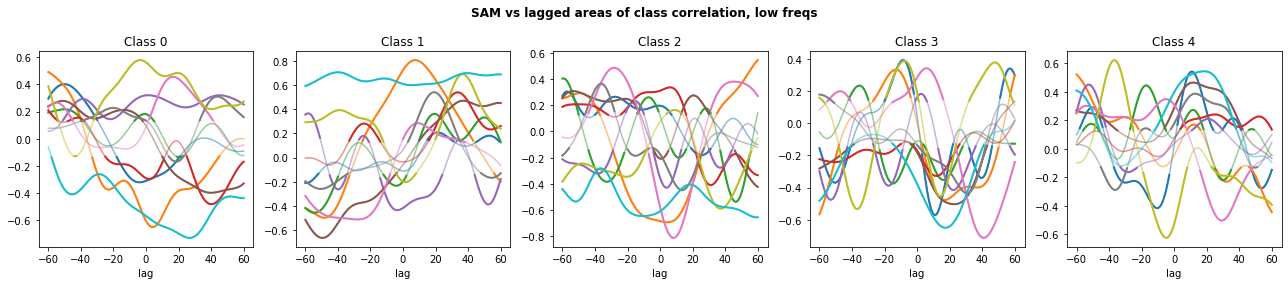

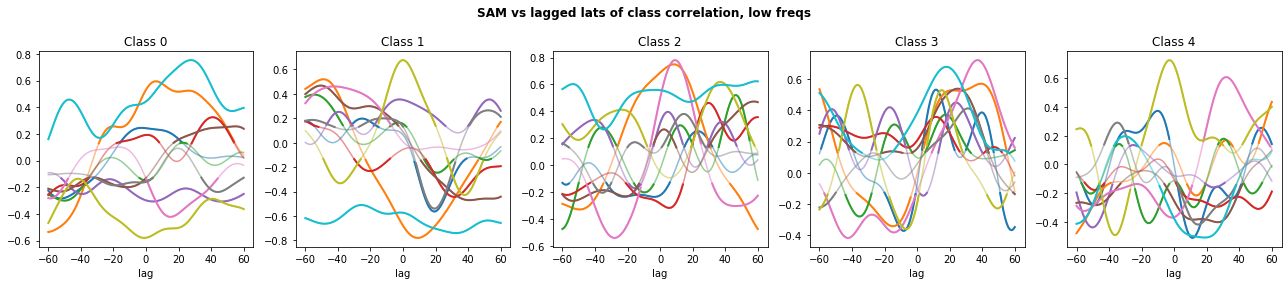

In [95]:
cmap=plt.cm.tab10
for var in ['areas','lats']:
    pp=1
    plt.figure(figsize=[18,4])
    for k in range(0,n_classes):
        ax=plt.subplot(1,n_classes,pp)
        ax.set_prop_cycle(color=cmap.colors[:10])
        plot1=all_stats.isel(k=k).sel(var=var,parameter='r_value')
        plot2=plot1.where(all_stats.isel(k=k).sel(var=var,parameter='p_value')<=0.05)
        plot1.plot(x='lag',hue='id',ax=ax,alpha=0.5,add_legend=False)
        plot2.plot(x='lag',hue='id',ax=ax,linewidth='2',add_legend=False)
        plt.title('Class {}'.format(k))
        if freq=='high':
            plt.xlim(-18,18)
        pp+=1
    plt.suptitle('SAM vs lagged {} of class correlation, {} freqs'.format(var,freq),fontweight='bold',fontsize=12)
    plt.tight_layout()
    plt.savefig('figures/SAMvs{}byClass-{}classes-{}freq'.format(var,n_classes,freq))